--- Simulating QKD Protocol (BB84 with Universal Gates) ---

--- QKD Round 1/10 ---
Alice: Preparing bit 1 in basis 'diagonal'.
Bob: Choosing basis 'diagonal'.
0 (d=3): ───Qutrit1Gate───Qu3H───Qu3H───Qu3H───Qu3H───M('diagonal_measurement')───
0 (d=3): ───Qu3M───Qu3M───Qu3M───Qu3M───Qu3M───Qu3M───Qu3M───Qu3M───Qu3M───Qu3M───Qu3M───Qu3M───Qu3M───Qu3M───Qu3M───Qu3M───Qu3M───Qu3M───M('diagonal_measurement')───
Bob: Measured bit 1 in basis 'diagonal'.
Bob: Measured bit 1 in basis 'diagonal'.
Alice and Bob used the same basis.
  Key established for this round: 1

--- QKD Round 2/10 ---
Alice: Preparing bit 2 in basis 'diagonal'.
Bob: Choosing basis 'rectilinear'.
0 (d=3): ───Qutrit2Gate───Qu3H───Qu3H───Qu3H───M('rectilinear_measurement')───
0 (d=3): ───Qu3M───Qu3M───Qu3M───Qu3M───Qu3M───Qu3M───Qu3M───Qu3M───Qu3M───Qu3M───Qu3M───Qu3M───Qu3M───Qu3M───M('rectilinear_measurement')───
Bob: Measured bit 1 in basis 'rectilinear'.
Bob: Measured bit 1 in basis 'rectilinear'.
Alice and Bob used differ

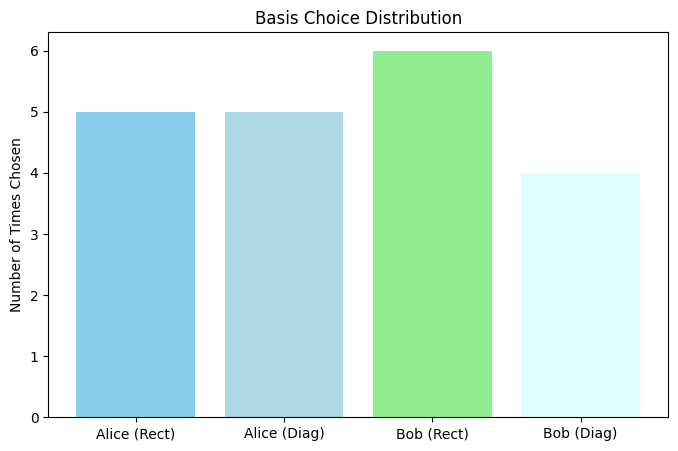

In [1]:
import cirq
import numpy as np
import random
import cmath
import matplotlib.pyplot as plt
from collections import Counter

# --- Universal Gate Set based on the Paper ---
# ... qutrit based state generation operators ...
class Qutrit2Gate(cirq.Gate):
    """
    A custom gate that swaps the |0> and |2> states of a qutrit,
    leaving |1> unchanged.
    """
    def __init__(self, d: int):
        self.name = "Qutrit2Gate"

    def _qid_shape_(self):
        return (3,) # It operates on a single qutrit

    def _unitary_(self):
        QUTRIT_SWAP_MATRIX = np.array([
            [0, 0, 1],  # First row: maps to |0> (from |2>)
            [0, 1, 0],  # Second row: maps to |1> (from |1>)
            [1, 0, 0]   # Third row: maps to |2> (from |0>)
        ])
        # Return the matrix for this gate
        return QUTRIT_SWAP_MATRIX

    def _circuit_diagram_info_(self, args):
        return self.name # Name for diagram
    
class Qutrit1Gate(cirq.Gate):
    """
    A custom gate that swaps the |0> and |2> states of a qutrit,
    leaving |1> unchanged.
    """
    def __init__(self, d: int):
        self.name = "Qutrit1Gate"

    def _qid_shape_(self):
        return (3,) # It operates on a single qutrit

    def _unitary_(self):
        QUTRIT_SWAP_MATRIX = np.array([
            [0, 1, 0], # First row: maps to |1> (from |0>)
            [1, 0, 0], # Second row: maps to |0> (from |1>)
            [0, 0, 1] # Third row: maps to |2> (from |2>)
        ])
        # Return the matrix for this gate
        return QUTRIT_SWAP_MATRIX

    def _circuit_diagram_info_(self, args):
        return self.name # Name for diagram
    
class QuditHGate(cirq.Gate):
    """A generalized Hadamard-like gate for qudits.

    This gate acts on a single d-level system (qudit).
    It implements a specific unitary transformation, which in the original
    example was a normalized DFT matrix. For this script's purpose,
    we assume it's a component for setting up the search space.

    Args:
        d (int): The number of levels in the qudit system.
                 This dictates the dimension of the Hilbert space.
    """
    def __init__(self, d: int):
        """Initializes the QuditHGate for a qudit of 'd' levels."""
        super().__init__()
        if not isinstance(d, int) or d <= 0:
            raise ValueError("The number of levels 'd' must be a positive integer.")
        self._d = d
        self.name = f'Qu{d}H' # Shorter name for circuit diagrams
        # This gate acts on a single qudit.
        self.num_qubits = 1

    def _qid_shape_(self):
        """Returns the shape of the qudit this gate acts on."""
        return (self._d,)

    def _unitary_(self):
        """Returns the unitary matrix for the gate.

        This specific implementation generates a normalized Discrete Fourier
        Transform (DFT) matrix of size d x d. This is a common component
        in quantum algorithms and signal processing.
        """
        d = self._d
        # Create indices i and j for the matrix elements.
        i, j = np.meshgrid(np.arange(d), np.arange(d))
        # The exponent determines the phase shift, based on (i * j) mod d.
        exponent = (i * j) % d
        # Calculate complex roots of unity and normalize.
        roots_of_unity = np.exp(2 * cmath.pi * 1j * exponent / d)
        normalized_matrix = roots_of_unity / np.sqrt(d)
        return normalized_matrix

    def _circuit_diagram_info_(self, args):
        """Provides information for circuit diagrams."""
        return f'Qu{self._d}H'
    
# --- Universal Decomposition ---

def reckon_decompose_unitary(M):
    """
    Decomposes an N x N unitary matrix M into a product of R_k matrices and a diagonal
    phase matrix Phi, such that M = R_1 @ R_2 @ ... @ R_L @ Phi.

    This algorithm is based on the Reck's decomposition method, which uses a sequence
    of Givens rotations to transform the unitary matrix into a diagonal matrix.

    Args:
        M (np.ndarray): An N x N complex numpy array representing a unitary matrix.

    Returns:
        tuple: A tuple containing:
            - R_matrices (list): A list of N x N numpy arrays, where each array is
                                 an R_k matrix (identity matrix with a 2x2 unitary
                                 block). The matrices are ordered such that
                                 M = R_matrices[0] @ R_matrices[1] @ ... @ R_matrices[-1] @ Phi.
            - Phi (np.ndarray): An N x N diagonal numpy array representing the
                                 final phase shift matrix.

    Raises:
        ValueError: If the input matrix is not square or is not unitary.
    """
    N = M.shape[0]
    if M.shape[1] != N:
        raise ValueError("Input matrix must be square.")
    
    # Check if M is unitary (M @ M.conj().T should be identity)
    if not np.allclose(M @ M.conj().T, np.eye(N)):
        raise ValueError("Input matrix is not unitary.")

    R_matrices = []
    U_current = M.astype(complex) # Ensure complex dtype for computations

    # Iterate through columns from left to right (j)
    for j in range(N - 1):
        # Iterate through rows from bottom up to j+1 (i)
        # to zero out elements below the diagonal in column j
        for i in range(N - 1, j, -1):
            u = U_current[j, j]
            v = U_current[i, j]

            # If the element to zero is already very small, skip
            if np.isclose(v, 0.0):
                continue

            r = np.sqrt(np.abs(u)**2 + np.abs(v)**2)

            # Construct the 2x2 Givens rotation block G_block
            # G_block @ [[u],[v]] = [[r],[0]]
            c = u.conjugate() / r
            s = v.conjugate() / r
            
            # The 2x2 block that zeros v when applied to [[u],[v]]
            G_block = np.array([[c, s],
                                [-s.conjugate(), c.conjugate()]], dtype=complex)

            # Construct the N x N R_inv_matrix (Givens rotation matrix)
            R_inv_matrix = np.eye(N, dtype=complex)
            R_inv_matrix[np.ix_([j, i], [j, i])] = G_block

            # Apply the rotation to U_current
            U_current = R_inv_matrix @ U_current

            # Store the R_k matrix (which is the inverse of R_inv_matrix, i.e., its conjugate transpose)
            R_matrices.append(R_inv_matrix.conj().T)

    Phi = U_current
    
    # Round small values to zero for cleaner diagonal matrix
    # and ensure phases are correct
    for k in range(N):
        if not np.isclose(np.abs(Phi[k, k]), 1.0):
             # This should not happen if M is unitary and calculations are precise
            print(f"Warning: Diagonal element Phi[{k},{k}] has magnitude {np.abs(Phi[k,k])} != 1.")
        # Make off-diagonal elements exactly zero if close to zero
        for l in range(N):
            if k != l and np.isclose(Phi[k, l], 0.0):
                Phi[k, l] = 0.0
    
    return R_matrices, Phi

# --- To define arbitrary operator from arbitrary matrix ---

class ArbitraryGate(cirq.Gate):
    """A generic gate that applies a given arbitrary unitary matrix.

    This is useful for applying decomposed gates (e.g., from Reck's algorithm).

    Args:
        d (int): The dimension of the qudit system this gate operates on.
                 Note: For multi-qubit/qudit gates, this parameter might need
                 adjustment or a different approach to specify the total system.
                 Here, it's mainly for diagram labeling.
        matrix (np.ndarray): The N x N unitary matrix to apply.
    """
    def __init__(self, d: int, matrix: np.ndarray):
        super().__init__()
        if not isinstance(d, int) or d <= 0:
            raise ValueError("The number of levels 'd' must be a positive integer.")
        if matrix.shape[0] != matrix.shape[1] or matrix.shape[0] != d:
             # This check is done to carry out data sanity check on the matrix dimension
            pass 

        self._d = d
        self._matrix = matrix
        self.name = f'Arb{d}' # Generic name for arbitrary gates
        self.num_qubits = 1 # QuditHGate acts on 1 qudit, so its decomposition is also on 1 qudit

    def _qid_shape_(self):
        """Returns the shape of the qudit this gate acts on."""
        return (self._d,) # Use the stored instance value of d

    def _unitary_(self):
        """Returns the unitary matrix for the gate."""
        d = self._d  # Retrieve the d value for this specific instance
        matrix = self._matrix
        return np.array(matrix)

    def _circuit_diagram_info_(self, args):
        """Provides information for circuit diagrams."""
        return f'Qu{self._d}M'
    
# --- Decomposing Qutrit Gates with Universal Gate Set (Setting Global Variables) ---

H_unitary = QuditHGate(d=3)._unitary_()
M1, M2 = reckon_decompose_unitary(H_unitary) #decomposing hadamard matrices

Qutrit1Gate_unitary = Qutrit1Gate(d=3)._unitary_()
M3, M4 = reckon_decompose_unitary(Qutrit1Gate_unitary) #decomposing Qutrit1Gate matrices

Qutrit2Gate_unitary = Qutrit2Gate(d=3)._unitary_()
M5, M6 = reckon_decompose_unitary(Qutrit2Gate_unitary) #decomposing Qutrit1Gate matrices

# --- Alice's Side (Using Operations Constructible from S) ---

def alice_prepares_bb84_state_universal(bit: int, basis_choice: str): # Corrected function name to match call
    """
    Alice prepares a qubit state for BB84 using operations constructible from S.
    (Conceptually, these operations are built from PHASE_1 and T_elements).

    Args:
        bit (int): The bit Alice wants to send (0 or 1).
        basis_choice (str): Alice's chosen basis ('rectilinear' or 'diagonal').

    Returns:
        cirq.Circuit: The quantum circuit for Alice's action.
        cirq.LineQubit: The qubit Alice uses.
        str: The basis Alice chose.  <-- ADDED THIS RETURN VALUE
        int: The bit Alice encoded.
    """
    qubit = cirq.LineQid(0, dimension=3)
    circuit = cirq.Circuit()
    circuit1 = cirq.Circuit()
    
    # The order for reconstruction is R_L, R_{L-1}, ..., R_1
    # So R_matrices_H[i] is R_{i+1} in the decomposition M = R1 @ ... @ RL @ Phi.
    repeated_h_ops_phi = [ArbitraryGate(d=3,matrix=M2)(qubit)]
    repeated_h_ops_R = [op for M in M1[::-1] for op in [ArbitraryGate(d=3,matrix=M)(qubit)]]
    
    repeated_Qutrit1Gate_ops_phi = [ArbitraryGate(d=3,matrix=M4)(qubit)]
    repeated_Qutrit1Gate_ops_R = [op for M in M3[::-1] for op in [ArbitraryGate(d=3,matrix=M)(qubit)]]
    
    repeated_Qutrit2Gate_ops_phi = [ArbitraryGate(d=3,matrix=M6)(qubit)]
    repeated_Qutrit2Gate_ops_R = [op for M in M5[::-1] for op in [ArbitraryGate(d=3,matrix=M)(qubit)]]  
    
    # We need to perform operations equivalent to X and H.
    # The paper's T_elements (SU(2) operations) can generate arbitrary single-qubit
    # rotations, which includes X (a specific rotation) and H (another specific rotation).
    # PHASE_1 provides Z-rotations.
    # Let's use Cirq's H and X, assuming they are implemented using S.

    # For rectilinear basis:
    # choice 0 -> |0> (No operation needed)
    # choice 1 -> |1> (apply Qutrit1Gate)
    # choice 2 -> |2> (apply Qutrit2Gate)
    if basis_choice == 'rectilinear':
        if bit == 1:
            circuit.append(Qutrit1Gate(d=3)(qubit))
            circuit1.append(repeated_Qutrit1Gate_ops_phi)
            circuit1.append(repeated_Qutrit1Gate_ops_R)
        if bit == 2:
            circuit.append(Qutrit2Gate(d=3)(qubit))
            circuit1.append(repeated_Qutrit2Gate_ops_phi)
            circuit1.append(repeated_Qutrit2Gate_ops_R)
    
    # For diagonal basis:
    # Bit 0 -> (|0> + |1>)/sqrt(2) (Equivalent to Hadamard)
    # Bit 1 -> (|0> - |1>)/sqrt(2) (Equivalent to X then Hadamard)
    elif basis_choice == 'diagonal':
        if bit == 0:
            circuit.append(QuditHGate(d=3)(qubit))
            circuit.append(QuditHGate(d=3)(qubit))
            circuit.append(QuditHGate(d=3)(qubit))
            circuit1.append(repeated_h_ops_phi)
            circuit1.append(repeated_h_ops_R)
            circuit1.append(repeated_h_ops_phi)
            circuit1.append(repeated_h_ops_R)
            circuit1.append(repeated_h_ops_phi)
            circuit1.append(repeated_h_ops_R)
        if bit == 1:
            circuit.append(Qutrit1Gate(d=3)(qubit))
            circuit1.append(repeated_Qutrit1Gate_ops_phi)
            circuit1.append(repeated_Qutrit1Gate_ops_R)
            circuit.append(QuditHGate(d=3)(qubit))
            circuit.append(QuditHGate(d=3)(qubit))
            circuit.append(QuditHGate(d=3)(qubit))
            circuit1.append(repeated_h_ops_phi)
            circuit1.append(repeated_h_ops_R)
            circuit1.append(repeated_h_ops_phi)
            circuit1.append(repeated_h_ops_R)
            circuit1.append(repeated_h_ops_phi)
            circuit1.append(repeated_h_ops_R)
        if bit == 2:
            circuit.append(Qutrit2Gate(d=3)(qubit))
            circuit1.append(repeated_Qutrit2Gate_ops_phi)
            circuit1.append(repeated_Qutrit2Gate_ops_R)
            circuit.append(QuditHGate(d=3)(qubit))
            circuit.append(QuditHGate(d=3)(qubit))
            circuit.append(QuditHGate(d=3)(qubit))
            circuit1.append(repeated_h_ops_phi)
            circuit1.append(repeated_h_ops_R)
            circuit1.append(repeated_h_ops_phi)
            circuit1.append(repeated_h_ops_R)
            circuit1.append(repeated_h_ops_phi)
            circuit1.append(repeated_h_ops_R)
    else:
        raise ValueError("Invalid basis choice for Alice.")

    # Return the basis choice made by Alice
    return circuit, circuit1, qubit, basis_choice, bit # Corrected return statement

# --- Bob's Side (Using Operations Constructible from S for Measurement) ---
def bob_measures_in_basis_universal(basis_choice: str, qubit: cirq.LineQubit): # Corrected function name
    """
    Bob measures in his chosen basis using operations constructible from S.
    Measurement in diagonal basis is achieved by applying Hadamard before measuring.

    Args:
        basis_choice (str): Bob's chosen basis ('rectilinear' or 'diagonal').
        qubit (cirq.LineQubit): The qubit Bob receives from Alice.

    Returns:
        cirq.Circuit: The quantum circuit for Bob's measurement.
        cirq.LineQubit: The qubit Bob measured.
        str: The basis Bob chose.  <-- ADDED THIS RETURN VALUE
    """
    circuit = cirq.Circuit()
    circuit1 = cirq.Circuit()
    measurement_key = f'{basis_choice}_measurement' # Unique key for the measurement
    
    # The order for reconstruction is R_L, R_{L-1}, ..., R_1
    # So R_matrices_H[i] is R_{i+1} in the decomposition M = R1 @ ... @ RL @ Phi.
    repeated_h_ops_phi = [ArbitraryGate(d=3,matrix=M2)(qubit)]
    repeated_h_ops_R = [op for M in M1[::-1] for op in [ArbitraryGate(d=3,matrix=M)(qubit)]]
    
    repeated_Qutrit1Gate_ops_phi = [ArbitraryGate(d=3,matrix=M4)(qubit)]
    repeated_Qutrit1Gate_ops_R = [op for M in M3[::-1] for op in [ArbitraryGate(d=3,matrix=M)(qubit)]]
    
    repeated_Qutrit2Gate_ops_phi = [ArbitraryGate(d=3,matrix=M6)(qubit)]
    repeated_Qutrit2Gate_ops_R = [op for M in M5[::-1] for op in [ArbitraryGate(d=3,matrix=M)(qubit)]] 

    # --- Operations constructible from S for measurement ---
    # To measure in a specific basis, we transform the state such that
    # the desired basis states align with the computational (rectilinear) basis,
    # and then perform a standard rectilinear measurement.

    if basis_choice == 'rectilinear':
        # Measure in the rectilinear (Z) basis. No extra gates needed as
        # Cirq's measure is in the Z-basis.
        pass
    elif basis_choice == 'diagonal':
        # To measure in the diagonal basis, we need to apply an operation
        # that maps the diagonal basis states to the rectilinear basis states.
        # The Hadamard gate (H) does this: H|(+)> = |0>, H|(-)> = |1>.
        # So, apply Hadamard before measurement. H is constructible from S.
        circuit.append(QuditHGate(d=3)(qubit))
#         circuit1.append(QuditHGate(d=3)(qubit))
        circuit1.append(repeated_h_ops_phi)
        circuit1.append(repeated_h_ops_R)
    else:
        raise ValueError("Invalid basis choice for Bob.")

    # Perform the measurement in the (now aligned) rectilinear basis.
    circuit.append(cirq.measure(qubit, key=measurement_key))
    circuit1.append(cirq.measure(qubit, key=measurement_key))

    return circuit, circuit1, qubit, basis_choice # Corrected return statement
# ... (bob_measures_in_basis_universal function remains the same) ...

# --- Simulation ---

def simulate_qkd_bb84_with_universal_gates(num_rounds: int):
    """
    Simulates QKD (BB84) using operations constructible from the paper's
    universal gate set S = PHASE_1 U T_elements.
    """
    print("--- Simulating QKD Protocol (BB84 with Universal Gates) ---")

    alice_basis_choices = []
    alice_sent_bits = []
    bob_basis_choices = []
    bob_measured_bits = []
    bob_measured_bits1 = []
    shared_key = []

    # Initialize Cirq simulator
    simulator = cirq.Simulator()

    for round_num in range(num_rounds):
        print(f"\n--- QKD Round {round_num + 1}/{num_rounds} ---")

        # 1. Alice prepares a bit and basis using operations from S
        alice_bit = random.choice([0, 1, 2])
        alice_basis = random.choice(['rectilinear', 'diagonal'])
        print(f"Alice: Preparing bit {alice_bit} in basis '{alice_basis}'.")

        # Corrected call to use the function that returns the basis
        alice_circuit, alice_circuit1, alice_qubit, chosen_alice_basis, encoded_alice_bit = alice_prepares_bb84_state_universal(alice_bit, alice_basis)
        
        alice_basis_choices.append(chosen_alice_basis)
        alice_sent_bits.append(encoded_alice_bit)

        # 2. Bob chooses a basis to measure using operations from S
        bob_basis = random.choice(['rectilinear', 'diagonal'])
        print(f"Bob: Choosing basis '{bob_basis}'.")

        bob_circuit, bob_circuit1, bob_qubit, chosen_bob_basis = bob_measures_in_basis_universal(bob_basis, alice_qubit)
        bob_basis_choices.append(chosen_bob_basis)

        # 3. Combine circuits for simulation
        full_circuit = alice_circuit + bob_circuit
        full_circuit1 = alice_circuit1 + bob_circuit1
        print(full_circuit)
        print(full_circuit1)

        # 4. Simulate the circuit
        result = simulator.run(full_circuit, repetitions=1)
        result1 = simulator.run(full_circuit1, repetitions=1)
#         result1 = simulator.run(alice_circuit, repetitions=1)
#         result2 = simulator.run(bob_circuit, repetitions=1)

        # 5. Extract Bob's measurement outcome
        bob_measurement = None
        bob_measurement1 = None
        measurement_key = f'{chosen_bob_basis}_measurement' # Use Bob's chosen basis for key
        bob_measurement_result = result.measurements.get(measurement_key)
        bob_measurement_result1 = result1.measurements.get(measurement_key)
        
        bob_measurement = bob_measurement_result[0][0]
        bob_measured_bits.append(bob_measurement)
        print(f"Bob: Measured bit {bob_measurement} in basis '{chosen_bob_basis}'.")
        bob_measurement1 = bob_measurement_result1[0][0]
        bob_measured_bits1.append(bob_measurement1)
        print(f"Bob: Measured bit {bob_measurement1} in basis '{chosen_bob_basis}'.")
        
        # 6. Alice and Bob compare bases and establish key bits
        shared_key_bit = None
        if chosen_alice_basis == chosen_bob_basis:
            print("Alice and Bob used the same basis.")
            shared_key_bit = encoded_alice_bit
            shared_key.append(shared_key_bit)
            print(f"  Key established for this round: {shared_key_bit}")
        else:
            print("Alice and Bob used different bases or measurement result invalid. No key bit established for this round.")

    print("\n--- QKD Simulation Complete ---")
    print(f"Total rounds simulated: {num_rounds}")
    print(f"Number of key bits established: {len(shared_key)}")
    print(f"Shared Secret Key: {''.join(map(str, shared_key))}")
    print(f"Bob's key with actual circuit: {bob_measured_bits}, and with universal gates' circuit: {bob_measured_bits1}")

    # --- Visualization of Basis Choices ---
    alice_basis_counts = Counter(alice_basis_choices)
    bob_basis_counts = Counter(bob_basis_choices)

    print("\n--- Basis Statistics ---")
    print(f"Alice's basis choices: {dict(alice_basis_counts)}")
    print(f"Bob's basis choices: {dict(bob_basis_counts)}")

    # Plotting basis choices
    plt.figure(figsize=(8, 5))
    plt.bar(['Alice (Rect)', 'Alice (Diag)', 'Bob (Rect)', 'Bob (Diag)'],
            [alice_basis_counts.get('rectilinear', 0),
             alice_basis_counts.get('diagonal', 0),
             bob_basis_counts.get('rectilinear', 0),
             bob_basis_counts.get('diagonal', 0)],
            color=['skyblue', 'lightblue', 'lightgreen', 'lightcyan'])
    plt.ylabel("Number of Times Chosen")
    plt.title("Basis Choice Distribution")
    plt.show()

# --- Run the Simulation ---
if __name__ == "__main__":
    simulate_qkd_bb84_with_universal_gates(num_rounds=10)